In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)

In [116]:
df = pd.read_csv('data/twitter_emotions.csv')
df.head(5)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [117]:
emotion_labels = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

sample_df = df[['text', 'label']].head(5)
sample_df['label'] = sample_df['label'].map(emotion_labels)
print(sample_df)

                                                text    label
0      i just feel really helpless and heavy hearted     Fear
1  ive enjoyed being able to slouch about relax a...  Sadness
2  i gave up my internship with the dmrg and am f...     Fear
3                         i dont know i feel so lost  Sadness
4  i am a kindergarten teacher and i am thoroughl...     Fear


In [118]:
df.shape

(416809, 3)

In [119]:
df.isna().mean() * 100

Unnamed: 0    0.0
text          0.0
label         0.0
dtype: float64

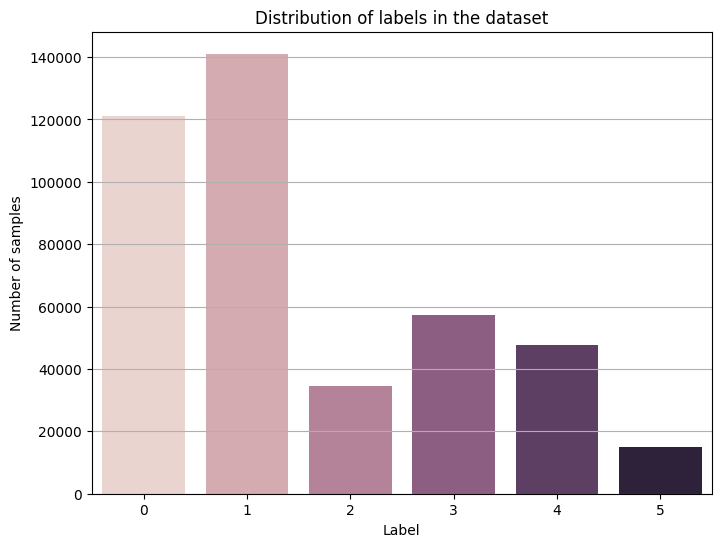

In [120]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, hue='label' , legend=False)
plt.title('Distribution of labels in the dataset')
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.grid(axis='y')
plt.show()

In [121]:
# We Balance the dataset to have equal number of samples for each label.
class EmotionDataset(Dataset):
    def __init__(self, df, length):
        self.df = df
        self.length = length
        self.df = self.balance_dataset(df)
    
    def balance_dataset(self, df):
        min = df['label'].value_counts().min()
        df = df.groupby('label').apply(lambda x: x.sample(min)).reset_index(drop=True)
        return df.sample(self.length)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __get_item__(self, idx):
        return self.df.iloc[idx,:]
    
    def __get_all_items__(self):
        return self.df

df = EmotionDataset(df, 30000)

C:\Users\mlasb\AppData\Local\Temp\ipykernel_9844\1058484019.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label').apply(lambda x: x.sample(min)).reset_index(drop=True)


In [122]:
df = df.__get_all_items__()
df.label.value_counts()

label
4    5069
1    5039
0    4987
2    4984
5    4982
3    4939
Name: count, dtype: int64

In [123]:
# Creating a BERT tokenizer and a BERT model for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Splitting the dataset into training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

train_set = train_set.tolist()
test_set = test_set.tolist()
train_labels = torch.tensor(np.array(train_labels), dtype=torch.long)
test_labels = torch.tensor(np.array(test_labels), dtype=torch.long)

# Tokenizing the training and testing sets by padding or truncating the sequences to a maximum length of 128
train_encodings = tokenizer(train_set, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(test_set, truncation=True, padding=True, max_length=128, return_tensors='pt')

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = torch.utils.data.TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Creating a DataLoader for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [3]:
class EmotionClassifier(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        self.linear = torch.nn.Linear(768, num_classes)
    
    def forward(self, inputs, attention_mask):
        outputs = self.bert_model(inputs, attention_mask)
        # We only need the pooled output of the [CLS] token
        outputs = self.linear(outputs.pooler_output)
        return outputs

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionClassifier(model, 6).to(device)

optimize = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(3):
    
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    for batch in train_loader:
        
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask)
        
        loss = criterion(outputs, labels)
        
        optimize.zero_grad()
        loss.backward()
        optimize.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / len(train_set)
    
    print(f'- Epoch {epoch}:')
    print(f'Training Loss: {train_loss:.2f} | Training Accuracy: {train_accuracy:.2f}')

# Saving the trained model
save_path = 'trained_model/bert_emotion_classifier.pth'
torch.save(model.state_dict(), save_path)


- Epoch 0:
Training Loss: 0.61 | Training Accuracy: 0.79
- Epoch 1:
Training Loss: 0.17 | Training Accuracy: 0.94
- Epoch 2:
Training Loss: 0.13 | Training Accuracy: 0.95


Test Accuracy: 0.95


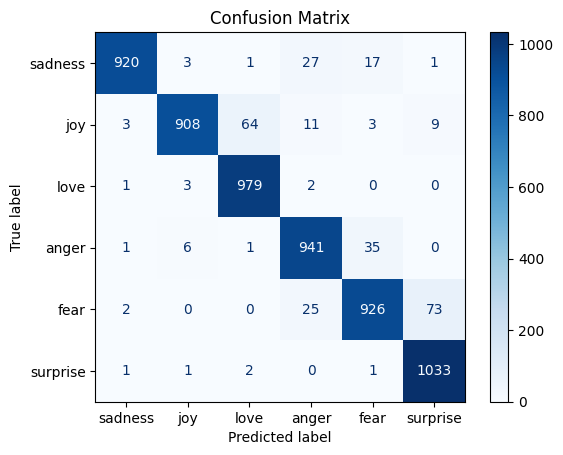

In [126]:

model.eval()
total_val_correct = 0
test_predictions = []
test_labels = []

with torch.no_grad():
    
    for batch in test_loader:
        
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask)

        total_val_correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
        
        test_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

val_accuracy = total_val_correct / len(test_set)
print(f'Test Accuracy: {val_accuracy:.2f}')

# Plot the confusion matrix
conf_matrix = confusion_matrix(np.array(test_labels), np.array(test_predictions), labels=[0, 1, 2, 3, 4, 5])

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# Saving the model to the Hugging Face Hub

from transformers import BertTokenizer, AutoModel
from huggingface_hub import notebook_login

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

num_classes = 6  
model = EmotionClassifier(bert_model, num_classes)

# Log in to the Hugging Face Hub (only needed if you're not logged in)
notebook_login()

# Save the model locally
model_save_path = 'trained_model/bert_emotion_classifier'
model.save_pretrained(model_save_path)

# Push the model to the Hugging Face Hub
model.push_to_hub("MaxLSB/bert-emotion-classification")

# You can also push the configuration to the Hub (optional, if you modified the configuration)
config = bert_model.config
config.save_pretrained(model_save_path)
config.push_to_hub("MaxLSB/bert-emotion-classification")

AttributeError: 'EmotionClassifier' object has no attribute 'save_pretrained'